In [1]:
import xarray as xr
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
zarr_array = xr.open_zarr('SW_04_SWP_01_2025-06-13.zarr')

depth_data = zarr_array['depth'][::7].values
date_data = zarr_array['time'][::7].values
zarr_array.close()
template_map = np.array([len(depth[~np.isnan(depth)]) for depth in depth_data]).argmax()
original_shape = depth_data[template_map].shape


mask = np.isnan(depth_data[template_map])
mask
averaged_depth = np.nanmean(depth_data, axis=(0))


C:\Users\jbroders\AppData\Local\Temp\ipykernel_67948\2632205126.py:12: RuntimeWarning: Mean of empty slice
  averaged_depth = np.nanmean(depth_data, axis=(0))


In [3]:

depth_data_post = depth_data[date_data > np.datetime64('2021-01-01')]
date_data_post = date_data[date_data > np.datetime64('2021-01-01')]


In [4]:
def random_masking(depths,mask,scale=1):
    random_mask = deepcopy(depths)
    for array in depths:
        array[mask] = np.random.random(size=np.sum(mask))*scale
        array[array==None] = 0
        array[array==np.nan] = 0
    return random_mask      
        
        

In [5]:

#def replace_non_common_nans(mask:np.ndarray,array:np.ndarray):
 #       nan_mask = np.isnan(array)
  #      array[~mask & nan_mask] = 0
   #     return array

#def test_nans(test:np.ndarray,control:np.ndarray):
 #       if len(test[~np.isnan(test)]) != len(control[~np.isnan(control)]):
  #              print("Dimensions wrong")


In [6]:
weeks_in=8
weeks_out=4

In [7]:
int(np.floor(depth_data.shape[0]/2))

350

In [8]:
int(np.floor(depth_data.shape[1]/2))

661

In [9]:
def downscale_array_avg(array, factor):
    reshaped_array = array.reshape((array.shape[0] // factor, factor, array.shape[1] // factor, factor))
    downscaled_array = reshaped_array.mean(axis=(1, 3))
    return downscaled_array

In [10]:
output_shape = (int(np.floor(depth_data.shape[1]/2)), int(np.floor(depth_data.shape[0]/2)))

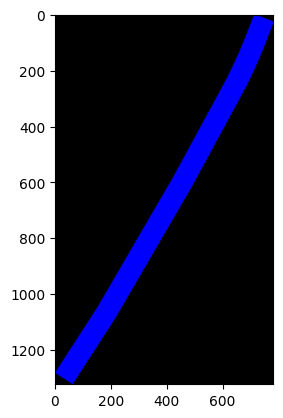

In [11]:
# Define the depth array
depth_array = depth_data_post[10]
normalized_depths = depth_array / np.max(depth_array)
# Create an RGB image where depths < 48 appear as red
colored_depths = np.zeros((*depth_array.shape, 3))  # Create an RGB image
colored_depths[..., 0] = np.where(depth_array < 50, 1, 0)  # Red channel
colored_depths[..., 1] = 0  # Green channel
colored_depths[..., 2] = np.where(depth_array > 50, 1, 0)  # Blue channel

plt.imshow(colored_depths)
plt.show()

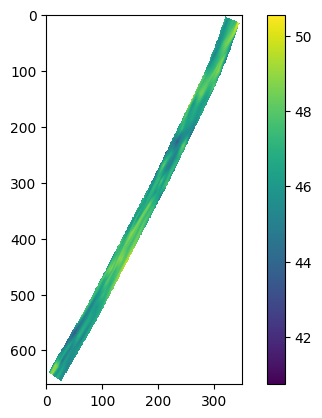

In [12]:
from skimage.transform import resize
reduced_depths = [depth for depth in depth_data if len(depth_data[template_map][~np.isnan(depth_data[template_map])]) == len(depth[~np.isnan(depth)])]
reduced_depths = [resize(depth, output_shape, anti_aliasing=True) for depth in reduced_depths]
plt.imshow(reduced_depths[10])
plt.colorbar()
plt.show()

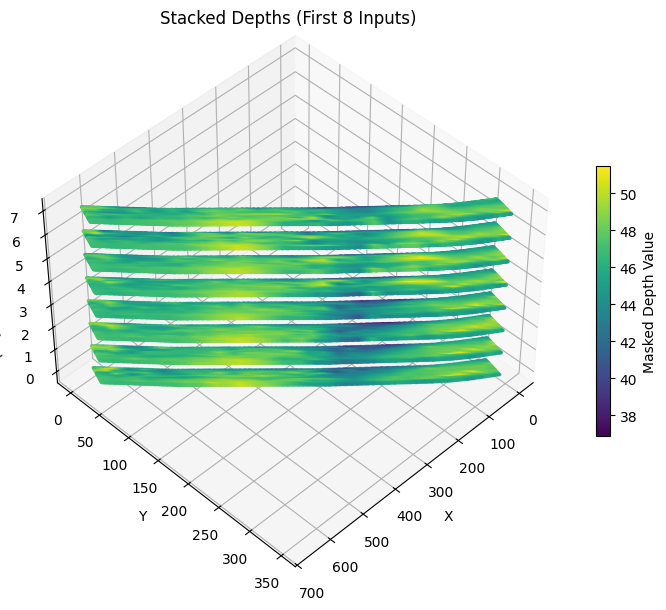

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


stacked = np.stack(reduced_depths[:8], axis=-1)


x = np.arange(stacked.shape[0])
y = np.arange(stacked.shape[1])
z = np.arange(stacked.shape[2])
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()
values_flat = stacked.flatten()

valid = ~np.isnan(values_flat)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_flat[valid], Y_flat[valid], Z_flat[valid], c=values_flat[valid], cmap='viridis', s=2)

ax.view_init(elev=45, azim=45)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Time (Input Index)')
plt.colorbar(sc, ax=ax, shrink=0.5, label='Masked Depth Value')
plt.title('Stacked Depths (First 8 Inputs)')
plt.show()

In [13]:
min([np.nanmin(depth) for depth in depth_data])

30.25678253173828

In [37]:
def dredge_percent_collection(depth, date):
    dredge_percent = []
    for arr, t in zip(depth, date):
        # Choose threshold depending on date
        threshold = 45 if t < np.datetime64("2020-01-01") else 50

        # Mask valid pixels (non-NaN)
        valid_mask = ~np.isnan(arr)

        # Compute below threshold fraction
        below_mask = (arr < threshold) & valid_mask
        percent_below = np.sum(below_mask) / np.sum(valid_mask)

        dredge_percent.append([percent_below, t])

    return dredge_percent


In [38]:
dredge_percent = dredge_percent_collection(depth_data,date_data)

In [39]:
dredge_percent = np.array(dredge_percent,dtype='object')

In [40]:
depth_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

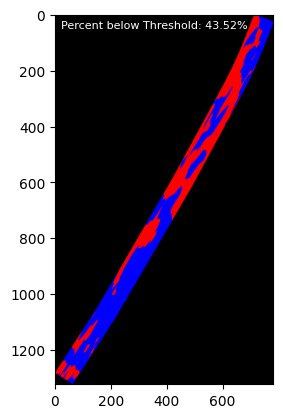

In [52]:
# Define the depth array
depth_array = depth_data[214]

# Mask out NaNs
valid_mask = ~np.isnan(depth_array)

# Compute percent below threshold the same way as dredge_percent
threshold = 45
below_mask = (depth_array < threshold) & valid_mask
percent_below = np.sum(below_mask) / np.sum(valid_mask)

# Create RGB visualization
colored_depths = np.zeros((*depth_array.shape, 3))
colored_depths[..., 0] = below_mask.astype(float)  # red = below threshold
colored_depths[..., 2] = ((depth_array >= threshold) & valid_mask).astype(float)  # blue = above threshold

plt.imshow(colored_depths)
plt.text(20, 50, f"Percent below Threshold: {percent_below*100:.2f}%", color='white',fontsize=8)
plt.show()


In [48]:
max_index = np.argmax(dredge_percent[:, 0])
max_index

214

In [62]:
date_data[214]

numpy.datetime64('2016-02-09T00:00:00.000000000')

In [47]:
dredge_percent[:,0].max()

0.43524228279417476

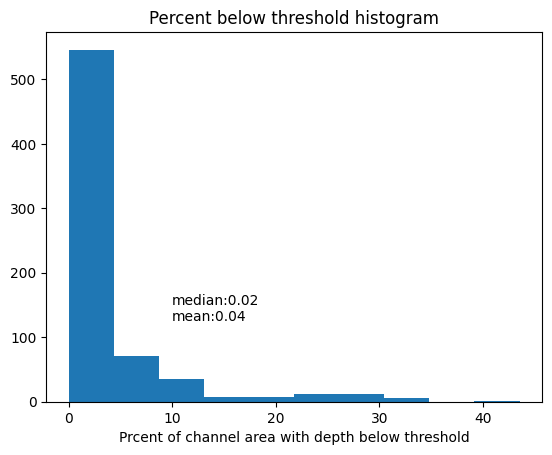

In [41]:
plt.hist(dredge_percent[:,0]*100,bins=10)
plt.xlabel('Prcent of channel area with depth below threshold')
plt.title('Percent below threshold histogram')
plt.text(10,125,f"mean:{np.mean(dredge_percent[:,0]):.2f}")
plt.text(10,150,f"median:{np.median(dredge_percent[:,0]):.2f}")
plt.show()

In [21]:
max_depth =80
min_depth = 20
percent_below = dredge_percent[:,0]
scaled_depths = [(arr - min_depth) / (max_depth - min_depth) for arr in reduced_depths]

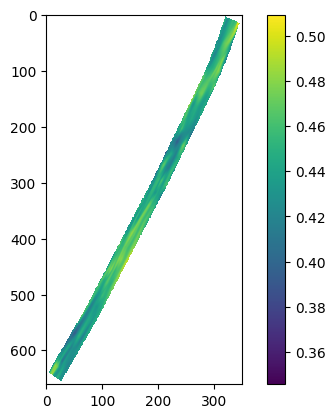

In [22]:
plt.imshow(scaled_depths[10])
plt.colorbar()
plt.show()

In [23]:

reduced_mask = np.isnan(reduced_depths[0])

In [24]:
masked_depths = random_masking(scaled_depths,reduced_mask,0)
masked_depths = random_masking(scaled_depths,reduced_mask,0)

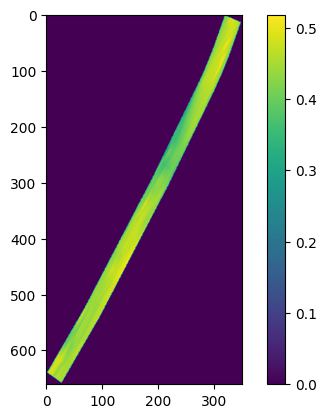

In [25]:
plt.imshow(masked_depths[1])
plt.colorbar()
plt.show()

In [26]:
percent_below

array([0.2209752706326348, 0.25685497341073865, 0.2231240802101861,
       0.24632761220307153, 0.15076878628373316, 0.12547061638331874,
       0.19907185872028457, 0.14887277783295264, 0.1488276347746007,
       0.06613458048555873, 0.08698164483247411, 0.015402811509674158,
       0.06063615597829522, 0.13746061268158796, 0.1107088363022418,
       0.06213490551557887, 0.060536841249921, 0.03411912350237904,
       0.05025325255735426, 0.05102971316100723, 0.05259166297998357,
       0.0484294729999368, 0.05245623380492782, 0.11343547702669761,
       0.10524652624165982, 0.10149965239845068, 0.040348865554943616,
       0.009814100885706806, 0.010626675936041314, 0.003385729376393792,
       0.005994998149134608, 0.0034399010464160927, 0.007927121046596665,
       0.002816926841159635, 0.006004026760804991, 0.0058234545273973225,
       0.009606442817287985, 0.009425870583880317, 0.009218212515461498,
       0.011312850422990456, 0.013678346680630919, 0.010491246760985564,
       0

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
percent_below_scaler = scaler.fit(percent_below.reshape(-1,1))

In [28]:
percent_below_scaled = percent_below_scaler.transform(percent_below.reshape(-1,1))

In [29]:
def create_sequences(data, input_length, output_length,y_predefined= None,date=None):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i + input_length:7])
        if y_predefined.any()== None:
            y.append(np.nanmin(data[i + input_length + output_length-1]))
        else:
            y.append(y_predefined[i+input_length+output_length-1])

    return np.array(X), np.array(y)


sequence_depths_X,sequence_depths_y = create_sequences(masked_depths, weeks_in*7, weeks_out*7,percent_below_scaled)

In [30]:
percent_below

array([0.2209752706326348, 0.25685497341073865, 0.2231240802101861,
       0.24632761220307153, 0.15076878628373316, 0.12547061638331874,
       0.19907185872028457, 0.14887277783295264, 0.1488276347746007,
       0.06613458048555873, 0.08698164483247411, 0.015402811509674158,
       0.06063615597829522, 0.13746061268158796, 0.1107088363022418,
       0.06213490551557887, 0.060536841249921, 0.03411912350237904,
       0.05025325255735426, 0.05102971316100723, 0.05259166297998357,
       0.0484294729999368, 0.05245623380492782, 0.11343547702669761,
       0.10524652624165982, 0.10149965239845068, 0.040348865554943616,
       0.009814100885706806, 0.010626675936041314, 0.003385729376393792,
       0.005994998149134608, 0.0034399010464160927, 0.007927121046596665,
       0.002816926841159635, 0.006004026760804991, 0.0058234545273973225,
       0.009606442817287985, 0.009425870583880317, 0.009218212515461498,
       0.011312850422990456, 0.013678346680630919, 0.010491246760985564,
       0

In [31]:
#train_X = np.moveaxis(train_X, 1, -1)
#test_X = np.moveaxis(test_X, 1, -1)
num_samples = len(sequence_depths_X)
indices = np.arange(num_samples)

train_X, test_X, train_y, test_y,  train_idx, test_idx = train_test_split(sequence_depths_X, sequence_depths_y, indices, test_size=0.2, random_state=42)
print(train_X.shape)

# Print shapes to verify

train_X = np.transpose(train_X,(0,2,3,1))
print(train_X.shape)
test_X = np.transpose(test_X,(0,2,3,1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y[:,0].tolist()))
test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y[:,0].tolist()))

train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)


(485, 8, 661, 350)
(485, 661, 350, 8)


In [32]:
# Calculate the number of samples corresponding to the final 6 weeks

validation_start_index =  -6

# Create validation dataset (only input data)
validation_X = sequence_depths_X[validation_start_index:-5]

# Print shape to verify
validation_X = np.transpose(validation_X,(0,2,3,1))
print("Validation X shape:", validation_X.shape)

Validation X shape: (1, 661, 350, 8)


In [33]:
train_dates = date_data[train_idx]
test_dates = date_data[test_idx]

In [34]:
print(test_X.shape)

(122, 661, 350, 8)


In [35]:

import visualkeras

c:\Users\jbroders\AppData\Local\anaconda3\envs\tf_test\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\jbroders\AppData\Local\anaconda3\envs\tf_test\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


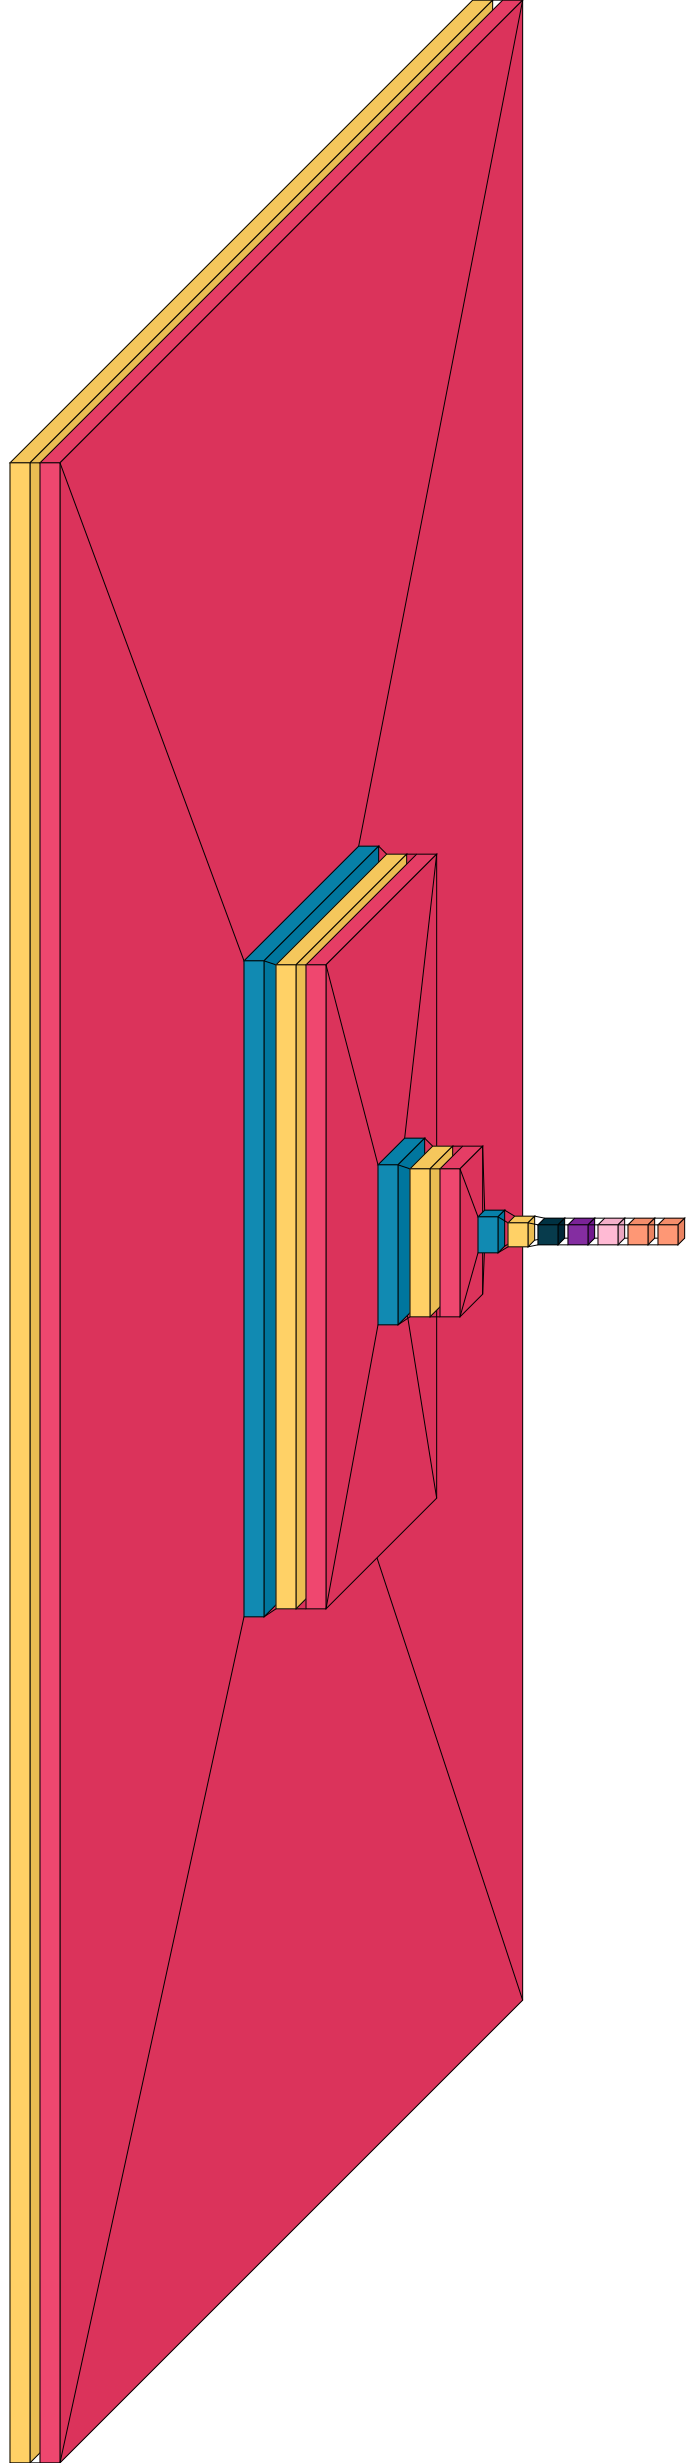

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, MaxPool3D, Flatten, Input,Dropout,Conv2D,Conv3D, MaxPool2D,GlobalAveragePooling2D,BatchNormalization

# Define your model
model = Sequential()
optimizer= tf.keras.optimizers.Adam(learning_rate=0.00005)

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu', input_shape=( output_shape[1], output_shape[0],weeks_in)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(4, 4)))

model.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(4, 4)))

model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(4, 4)))


model.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1))

# Compile your model
model.compile(optimizer=optimizer, loss='mse',metrics = ['mae'])


visualkeras.layered_view(model).show() # display using your system viewer

visualkeras.layered_view(model)

In [37]:
history = model.fit(train_dataset,epochs=300, validation_data=(test_dataset),callbacks=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=15, start_from_epoch=0,restore_best_weights=True))

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.8600 - mae: 0.9042 - val_loss: 1.4808 - val_mae: 1.2092
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.3884 - mae: 0.5906 - val_loss: 1.4236 - val_mae: 1.1853
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.1517 - mae: 0.3526 - val_loss: 1.3746 - val_mae: 1.1645
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0758 - mae: 0.2115 - val_loss: 1.3389 - val_mae: 1.1491
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0629 - mae: 0.1824 - val_loss: 1.3129 - val_mae: 1.1377
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0452 - mae: 0.1550 - val_loss: 1.2927 - val_mae: 1.1288
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0512 - mae: 0.1637 - val_loss: 1.2753 - val_mae: 1.1211
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0538 - mae: 0.1698 - val_loss: 1.2600 - val_mae: 1.1143
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0473 - mae: 0.1588 - val_loss

In [38]:
pred_y = model.predict(test_X,verbose=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


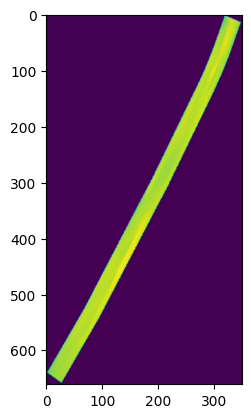

In [39]:
plt.imshow(test_X[0,:,:,0])

In [40]:
import tensorflow as tf
import numpy as np

# Define the Monte Carlo Dropout function to run stochastic forward passes
def monte_carlo_dropout(model, input_data, num_samples=100):
    """
    Run multiple stochastic forward passes with dropout on during inference.
    Args:
    - model: Trained model.
    - input_data: Input data for the model (e.g., a batch of samples).
    - num_samples: Number of forward passes to make for uncertainty estimation.
    
    Returns:
    - mean_pred: Mean prediction from multiple passes.
    - uncertainty: Standard deviation (uncertainty) from the predictions.
    """
    
    # Use tf.function for speed-up (graph execution)
    @tf.function
    def predict_with_dropout(inputs):
        # 1 indicates training mode, which means dropout will be active during inference
        return model(inputs, training=True)

    # Perform multiple stochastic forward passes
    predictions = []
    for _ in range(num_samples):
        pred = predict_with_dropout(input_data)
        predictions.append(pred.numpy())  # Convert tensor to numpy array
    
    predictions = np.array(predictions)
    
    # Calculate the mean and standard deviation (uncertainty) from the predictions
    mean_pred = predictions.mean(axis=0)
    uncertainty = predictions.std(axis=0)
    
    return mean_pred, uncertainty

In [41]:
model.save('reach_4_CNN.keras')

In [42]:
# Perform Monte Carlo Dropout and get both predictions and uncertainty
mean_pred, uncertainty = monte_carlo_dropout(model, test_X, num_samples=25)

In [43]:
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

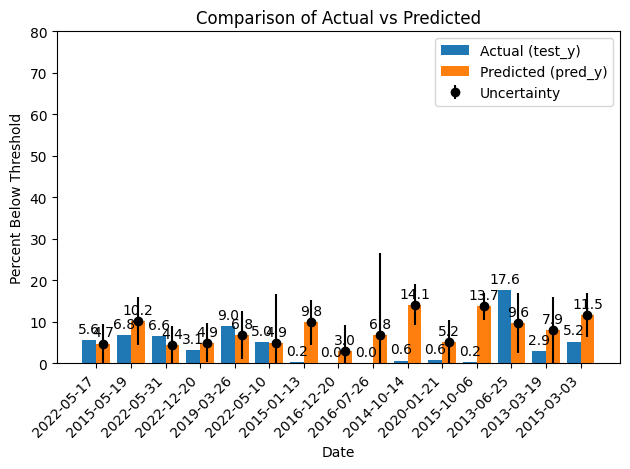

In [44]:
x = np.arange(len(pred_y[50:65]))  # Create an array of indices for the bars

dates_np = date_data[test_idx][50:65]
dates = [pd.Timestamp(d).to_pydatetime() for d in dates_np]

# Convert datetime objects to string in desired format
dates_str = [d.strftime('%Y-%m-%d') for d in dates]

width = 0.4  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, test_y[50:65,0]*100
                ,width, label='Actual (test_y)')
rects2 = ax.bar(x + width/2, pred_y[50:65].flatten()
                *100
                ,width, label='Predicted (pred_y)')

errorbar= ax.errorbar(x + width/2, pred_y[50:65].flatten()*100, yerr=uncertainty[50:65].flatten()*100, fmt='o', color='black', label='Uncertainty')

# Add labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Percent Below Threshold')
ax.set_title('Comparison of Actual vs Predicted')
ax.set_xticks(x)
ax.set_xticklabels(dates_str, rotation=45, ha='right')
ax.legend()

# Optionally, add value labels on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',  # Format to 2 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Rotate date labels for better readability
plt.xticks(rotation=45)
plt.ylim(0,80)
fig.tight_layout()



plt.show()


In [45]:
rmse = np.sqrt(np.mean((pred_y[:,0] - test_y.flatten()) ** 2))
mae = np.mean(np.abs((pred_y[:,0] - test_y.flatten())))
print(f"RMSE:{rmse.round(3)}")
print(f"Mae:{mae.round(3)}")

RMSE:0.13
Mae:0.073


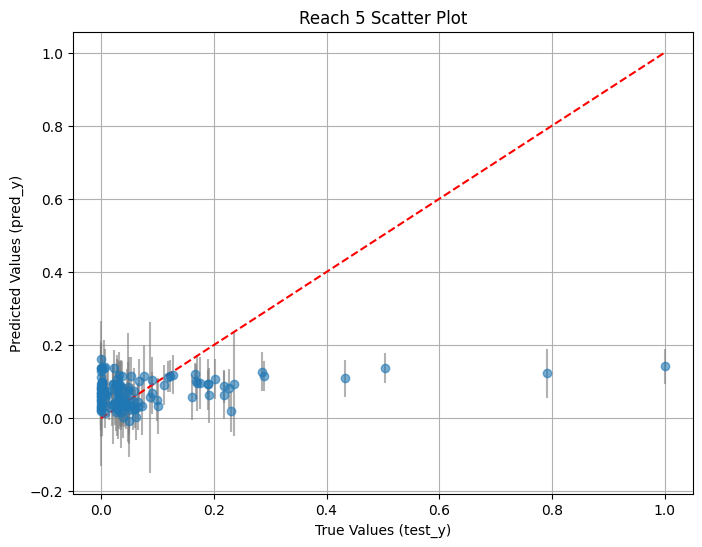

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Example: replace these with your actual data
# pred_y = np.array([...])
# test_y = np.array([...])
# uncertainty = np.array([...])  # same shape as test_y

plt.figure(figsize=(8, 6))

# Scatter plot with error bars
plt.errorbar(test_y, pred_y.flatten(), yerr=uncertainty.flatten(), fmt='o', ecolor='gray', alpha=0.6)

# Reference line: perfect predictions
plt.plot([0, 1], [0, 1], 'r--')

# Labels and title
plt.xlabel("True Values (test_y)")
plt.ylabel("Predicted Values (pred_y)")
plt.title("Reach 5 Scatter Plot")
plt.grid(True)
plt.show()

In [47]:
def mae_with_uncertainty(y_true, y_pred, y_std):
    mae = np.mean(np.abs(y_true - y_pred))
    mae_uncertainty = np.sqrt(np.sum(y_std**2)) / len(y_std)
    return mae, mae_uncertainty

mae_with_uncertainty(test_y[:,0], pred_y.flatten(), uncertainty.flatten())

(0.07294879125997265, 0.006259363205706487)

In [48]:
def rmse_with_uncertainty(y_true, y_pred, y_std):
    residuals = y_true - y_pred
    n = len(y_true)
    
    rmse = np.sqrt(np.mean(residuals ** 2))
    
    # Avoid division by zero
    if rmse == 0:
        rmse_uncertainty = 0.0
    else:
        rmse_uncertainty = np.sqrt(np.sum((residuals**2) * (y_std**2)) / (n * rmse**2))

    return rmse, rmse_uncertainty
rmse_with_uncertainty(test_y[:,0], pred_y.flatten(), uncertainty.flatten())

(0.12952554208342262, 0.05797736285663667)